## In this notebook, I explore a mathematical model to identify which parameter(s) have the greatest impact on solar panel yield.

In [1]:
# Only run this once to install packages
!pip install pandas matplotlib numpy pvlib requests knmy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, urllib, urllib3, time, warnings
from pvlib.solarposition import get_solarposition
from pvlib import irradiance
from matplotlib.collections import PolyCollection
import knmy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

plt.close('all')
warnings.filterwarnings('ignore')


## Define Configs and Month Lookup

In [3]:
# Month dictionary
number_to_month = {
    1 : ['January', 31], 2 : ['February', 28], 3 : ['March', 31],
    4 : ['April', 30],   5 : ['May', 31],       6 : ['June', 30],
    7 : ['July', 31],    8 : ['August', 31],    9 : ['September', 30],
    10: ['October', 31], 11: ['November', 30], 12: ['December', 31]
}


In [4]:
class Color:
    W       = '\033[0m'
    R       = '\033[1;31;48m'
    G       = '\033[32m'
    B       = '\033[34m'
    O       = '\033[33m'
    LB      = '\033[1;34;48m'
    P       = '\033[35m'
    C       = '\033[36m'
    WBLACK  = '\033[1;37;40m'
    WBLUE   = '\033[1;37;44m'
    END     = '\033[1;37;0m'
    WR      = '\033[1;37;41m'
    BG      = '\033[1;40;42m'

## Load KNMI Weather Data

In [5]:
# url = 'https://www.knmi.nl/nederland-nu/klimatologie/uurgegevens'
print('loading KNMI data from file ...')
df = pd.read_csv('df_KNMI.csv')
df.head()

loading KNMI data from file ...


,Unnamed: 0,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,Q,SQ,VV,N,U,P
0,0,330,20240101,1,210,120,120,180,75,NaN,61,0,0,NaN,NaN,91,9951
1,1,330,20240101,2,210,90,100,150,74,NaN,62,0,0,NaN,NaN,91,9958
2,2,330,20240101,3,240,100,110,160,92,NaN,59,0,0,NaN,NaN,79,9959
3,3,330,20240101,4,240,110,110,190,91,NaN,59,0,0,NaN,NaN,80,9966
4,4,330,20240101,5,240,100,100,150,95,NaN,54,0,0,NaN,NaN,76,9973


In [6]:
# Date formatting
df['HH'] = df['HH'].astype(str).str.zfill(2)
df['YYYYMMDDHH'] = df['YYYYMMDD'].astype(str) + df['HH'].astype(str).replace('24','00')
df['YYYYMMDDHH'] = pd.to_datetime(df['YYYYMMDDHH'], format = '%Y%m%d%H', errors = 'coerce')
df['YYYYMMDDHH'] = np.where(df['YYYYMMDDHH'].dt.strftime('%H:%M') == '00:00',
                       df['YYYYMMDDHH'] + pd.DateOffset(days = 1),
                       df['YYYYMMDDHH'])


In [7]:
drop_columns = ['YYYYMMDD', 'HH', 'DD', 'T10N', 'TD', 'VV', 'STN']
df = df.drop(columns = drop_columns)
df.insert(0, 'YYYYMMDDHH', df.pop('YYYYMMDDHH'))
print(df.head())

           YYYYMMDDHH  Unnamed: 0   FH   FF   FX   T  Q  SQ   N   U     P
0 2024-01-01 01:00:00           0  120  120  180  75  0   0 NaN  91  9951
1 2024-01-01 02:00:00           1   90  100  150  74  0   0 NaN  91  9958
2 2024-01-01 03:00:00           2  100  110  160  92  0   0 NaN  79  9959
3 2024-01-01 04:00:00           3  110  110  190  91  0   0 NaN  80  9966
4 2024-01-01 05:00:00           4  100  100  150  95  0   0 NaN  76  9973


In [8]:
df[23:]

,YYYYMMDDHH,Unnamed: 0,FH,FF,FX,T,Q,SQ,N,U,P
23,2024-01-02 00:00:00,23,110,120,150,76,0,0,NaN,94,9967
24,2024-01-02 01:00:00,24,130,130,180,79,0,0,NaN,94,9943
25,2024-01-02 02:00:00,25,130,130,170,81,0,0,NaN,94,9919
26,2024-01-02 03:00:00,26,120,110,160,85,0,0,NaN,96,9902
27,2024-01-02 04:00:00,27,110,110,150,97,0,0,NaN,96,9896
...,...,...,...,...,...,...,...,...,...,...,...
739,2024-01-31 20:00:00,739,110,110,160,68,0,0,NaN,78,10251
740,2024-01-31 21:00:00,740,110,120,170,78,0,0,NaN,80,10248
741,2024-01-31 22:00:00,741,120,120,170,78,0,0,NaN,85,10240
742,2024-01-31 23:00:00,742,110,100,170,79,0,0,NaN,94,10240


In [9]:
# New column names 
new_column_names = { 
    'FH' : 'average windspeed (m/s)',
    'FF' : 'windspeed previous 10 minuten (m/s)',
    'FX' : 'highest windspeed (m/s)',
    'T'  : 'temperature in degrees Celcius',
    'SQ' : 'duration of sunshine (h)',
    'Q'  : 'global radiation (in J/m^2)',    
    'P'  : 'air pressure (Pa)',
    'N'  : 'cloud cover (-)',
    'U'  : 'relative humidity (in percentages)'
}
df = df.rename(columns = new_column_names)

In [10]:
df.head()

,YYYYMMDDHH,Unnamed: 0,average windspeed (m/s),windspeed previous 10 minuten (m/s),highest windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),duration of sunshine (h),cloud cover (-),relative humidity (in percentages),air pressure (Pa)
0,2024-01-01 01:00:00,0,120,120,180,75,0,0,NaN,91,9951
1,2024-01-01 02:00:00,1,90,100,150,74,0,0,NaN,91,9958
2,2024-01-01 03:00:00,2,100,110,160,92,0,0,NaN,79,9959
3,2024-01-01 04:00:00,3,110,110,190,91,0,0,NaN,80,9966
4,2024-01-01 05:00:00,4,100,100,150,95,0,0,NaN,76,9973


In [11]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [12]:
# Group variables
windvariabelen = ['average windspeed (m/s)',
                  'windspeed previous 10 minuten (m/s)', 
                  'highest windspeed (m/s)' ]
temperature_variables = ['temperature in degrees Celcius'],
air_pressurevariabelen = ['air pressure (Pa)']
zonvariabelen = ['duration of sunshine (h)', 'global radiation (in J/m^2)']

# Physical constants
area_of_solar_panel = 2.45         ## area of one module [m^2]
efficiency_solar_panel = 0.20  ## efficiency of one solar panel [-]
number_of_solar_panels = 2   ## total number of solar panels used [-]
lat = 51.96811434560797             ## latitude of plant
lon = 4.095795682209092             ## longitude of plant
module = \
    {'theta_M': np.deg2rad(20),
     'azimuth': np.deg2rad(115)}

# Convert to S.I. units
for column in zonvariabelen:
    if column == 'duration of sunshine (h)':
        df[column] *= 0.10
    elif column == 'global radiation (in J/m^2)':
        df[column] *= 1e4

In [13]:
# Get the elevation of the module
def make_remote_request(url: str, params: dict):
    global response
    while True:
        try:
            response = requests.get(url + urllib.parse.urlencode(params))
        except (OSError, urllib3.exceptions.ProtocolError) as error:
            print(error)
            continue
        break

    return response

def elevation_function(lat, lon):
    url = 'https://api.opentopodata.org/v1/eudem25m?'
    params = {'locations': f"{lat},{lon}"}
    result = make_remote_request(url, params)
    if 'results' in result.json().keys():
        return_value = result.json()['results'][0]['elevation']
    else:
        return_value = None
    return return_value

In [14]:
elevation_module = elevation_function(lat, lon)
while elevation_module == None:
    time.sleep(0.40)
    elevation_module = elevation_function(lat, lon)

In [15]:
# Calculate the positions of the sun
date_time_or_doy = df['YYYYMMDDHH'] 
solpos = get_solarposition(
    time = date_time_or_doy, latitude = lat,
    longitude = lon, altitude = elevation_module,
    pressure = df['air pressure (Pa)'].values, 
    temperature = df['temperature in degrees Celcius'].values) 

In [16]:
# Orientation parameters
theta_M = module['theta_M']                     ## tilt angle module
az_M = module['azimuth']                        ## azimuth angle module

# Compute G_module, first decompose the ghi into dni and dhi
ghi = df['global radiation (in J/m^2)'].values  ## global horizontal irradiance in [J/m^2]
out_erbs = irradiance.erbs(ghi, solpos.zenith, solpos.index)
out_erbs = out_erbs.rename(columns = {'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})
dni = out_erbs['dni_erbs'].values               ## direct normal irradiance. [J/m^2]
dhi = out_erbs['dhi_erbs'].values               ## diffuse horizontal irradiance in [J/m^2]
sky_model = 'isotropic'
poa = irradiance.get_total_irradiance(np.rad2deg(theta_M), np.rad2deg(az_M),
                         solpos.zenith, solpos.azimuth,
                         dni, ghi, dhi, dni_extra = None, airmass = None,
                         surface_type = 'sea',
                         model = sky_model)
G_module = poa['poa_global'].values

In [17]:
poa.sample(5)

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
YYYYMMDDHH,,,,,
2024-01-04 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-06 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-12 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-26 05:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-13 09:00:00,58391.357379,55154.680127,3236.677252,3200.492824,36.184428


In [18]:
# Store into the dataframe
df['yield solar panel (kWh)'] = \
    (G_module * area_of_solar_panel * number_of_solar_panels * efficiency_solar_panel) / (1e3 * 3600 )
print("Last data frame after calculations/n")

Last data frame after calculations/n


In [19]:
poa.sample(5)

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
YYYYMMDDHH,,,,,
2024-01-05 16:00:00,9716.555318,0.000000,9716.555318,9698.463104,18.092214
2024-01-01 11:00:00,771279.975318,693599.721274,77680.254044,76811.827783,868.426261
2024-01-18 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-13 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
df['Plane-of-Array_irradiance']= poa['poa_global'].values / (1e3 * 3600 )

In [21]:
df.to_csv('data_experimenting/df_with_calculations.csv')

In [22]:
value = df.iloc[586]["yield solar panel (kWh)"]  ###when efficiency_solar_panel = 0.18 
print(f"yield solar panel (kWh): {value}")

yield solar panel (kWh): 0.11018264037731812


In [23]:
value = df.iloc[537]["yield solar panel (kWh)"] ###when efficiency_solar_panel = 0.20
print(f"yield solar panel (kWh): {value}")

yield solar panel (kWh): 0.2864580232551898


In [24]:
value = df.iloc[537]["yield solar panel (kWh)"] # ## total number of solar panels used [2] and effiency = 0.20
print(f"yield solar panel (kWh): {value}")

yield solar panel (kWh): 0.2864580232551898


This evaluation demonstrates how changing key parameters influences solar energy yield. In lines 42, increasing the solar panel efficiency led to a higher energy output. In line 45, adding an extra solar panel also increased the total energy generated, as expected.

In [25]:
visualisation_year = [2024]
visualisation_month = [1]
number_of_weather_station = 330

In [26]:
# Visualisation parameters
visualisation_day = range(1, number_to_month[visualisation_month[0]][1] + 1)

df_visualisation = df[
    (df['YYYYMMDDHH'].dt.year.isin(visualisation_year)) &
    (df['YYYYMMDDHH'].dt.month.isin(visualisation_month)) &
    (df['YYYYMMDDHH'].dt.day.isin(visualisation_day))
]

Text(0.5, 0, '[kWh]')

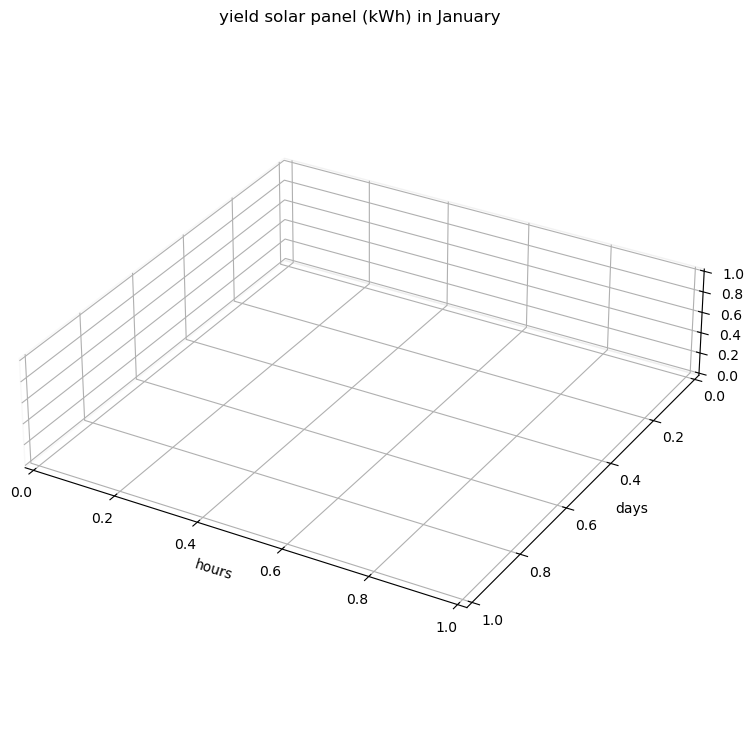

In [27]:
# Initialize plot
fig = plt.figure(figsize = (9, 9))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
plt.style.use('default')
ax.set_box_aspect((1, 1, 0.25))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.invert_yaxis()
field = 'yield solar panel (kWh)'    
str_ = field + ' in ' + number_to_month[visualisation_month[0]][0]
ax.set_title(str_)
ax.set_xlabel('hours')
ax.set_ylabel('days')
ax.set_zlabel('[kWh]')

In [28]:

correlation_matrix = df.corr(method='pearson')
print(correlation_matrix['yield solar panel (kWh)'])


YYYYMMDDHH                             0.117744
average windspeed (m/s)               -0.022488
windspeed previous 10 minuten (m/s)   -0.037468
highest windspeed (m/s)               -0.026334
temperature in degrees Celcius         0.018639
global radiation (in J/m^2)            0.938440
duration of sunshine (h)               0.787757
cloud cover (-)                             NaN
relative humidity (in percentages)    -0.306935
air pressure (Pa)                      0.110616
yield solar panel (kWh)                1.000000
Plane-of-Array_irradiance              1.000000
Name: yield solar panel (kWh), dtype: float64


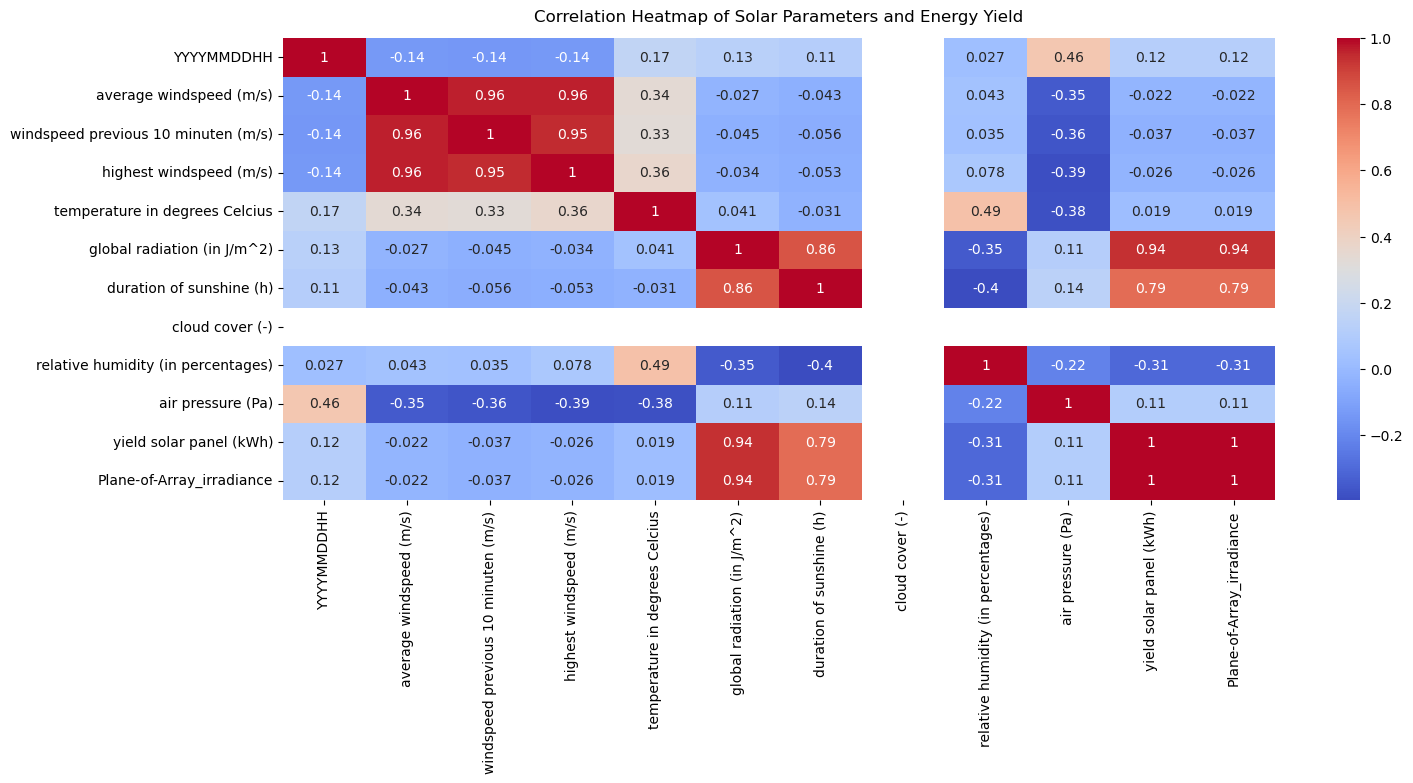

In [29]:
plt.figure(figsize=(16, 6))
heatmap=sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap of Solar Parameters and Energy Yield', fontdict={'fontsize':12}, pad=12);

###### The heatmap analysis reveals that global radiation and duration of sunshine are the most influential factors in determining solar panel yield. These parameters show a strong correlation with energy output, indicating their primary role in solar generation. In the next phase, I plan to store the angle parameters such as tilt and azimuth into a DataFrame and visualize their impact to assess whether panel orientation significantly affects energy yield.

###  Solar Yield Using Angle.

In [30]:
# Orientation parameters
theta_M = module['theta_M']                     # tilt angle [rad]
az_M = module['azimuth']                        # azimuth [rad]

# Extract GHI
ghi = df['global radiation (in J/m^2)'].values

# Decompose GHI into DNI, DHI using Erbs model
out_erbs = irradiance.erbs(ghi, solpos.zenith, solpos.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})
dni = out_erbs['dni_erbs'].values
dhi = out_erbs['dhi_erbs'].values

# Compute plane-of-array irradiance
poa = irradiance.get_total_irradiance(
    surface_tilt=np.rad2deg(theta_M),
    surface_azimuth=np.rad2deg(az_M),
    solar_zenith=solpos.zenith,
    solar_azimuth=solpos.azimuth,
    dni=dni, ghi=ghi, dhi=dhi,
    dni_extra=None, airmass=None,
    surface_type='sea',
    model='isotropic'
)

# Final irradiance hitting the panel
G_module = poa['poa_global'].values


In [31]:
# Physical constants
area_of_solar_panel = 2.45
efficiency_solar_panel = 0.20
number_of_solar_panels = 2

# Convert to kWh
df['solar_yield_kWh'] = (
    G_module * area_of_solar_panel * efficiency_solar_panel * number_of_solar_panels
) / (1e3 * 3600)


 a range of tilt angles (in degrees) from 10° to 60° in steps of 5°. It's used for sensitivity analysis,to see how changing the panel's tilt angle affects the solar yield. And by looping over these angles, you can visualize which tilt gives the highest energy yield.

In [32]:
angles_deg = np.arange(10, 90, 5)+
avg_yields = []

for angle in angles_deg:
    poa_temp = irradiance.get_total_irradiance(
        surface_tilt=angle,
        surface_azimuth=np.rad2deg(az_M),
        solar_zenith=solpos.zenith,
        solar_azimuth=solpos.azimuth,
        dni=dni, ghi=ghi, dhi=dhi,
        model='isotropic',
        surface_type='sea'
    )
    G_temp = poa_temp['poa_global'].values
    yield_kWh = (
        G_temp * area_of_solar_panel * efficiency_solar_panel * number_of_solar_panels
    ) / (1e3 * 3600)
    avg_yields.append(yield_kWh.mean())



### avg_yields

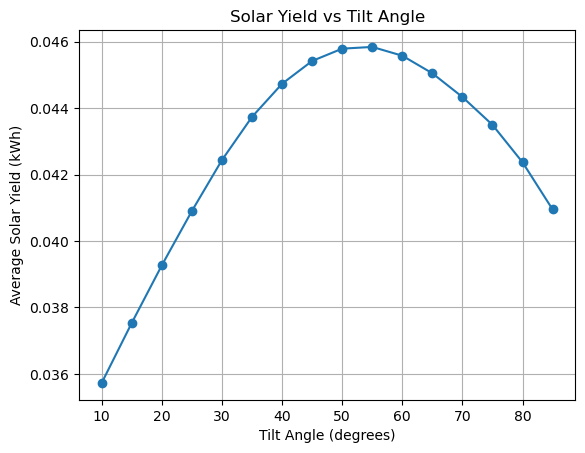

In [33]:
# Plot results
import matplotlib.pyplot as plt
plt.plot(angles_deg, avg_yields, marker='o')
plt.xlabel('Tilt Angle (degrees)')
plt.ylabel('Average Solar Yield (kWh)')
plt.title('Solar Yield vs Tilt Angle')
plt.grid(True)
plt.show()

In [34]:
df.tail()

,YYYYMMDDHH,average windspeed (m/s),windspeed previous 10 minuten (m/s),highest windspeed (m/s),temperature in degrees Celcius,global radiation (in J/m^2),duration of sunshine (h),cloud cover (-),relative humidity (in percentages),air pressure (Pa),yield solar panel (kWh),Plane-of-Array_irradiance,solar_yield_kWh
739,2024-01-31 20:00:00,110,110,160,68,0.0,0.0,NaN,78,10251,0.0,0.0,0.0
740,2024-01-31 21:00:00,110,120,170,78,0.0,0.0,NaN,80,10248,0.0,0.0,0.0
741,2024-01-31 22:00:00,120,120,170,78,0.0,0.0,NaN,85,10240,0.0,0.0,0.0
742,2024-01-31 23:00:00,110,100,170,79,0.0,0.0,NaN,94,10240,0.0,0.0,0.0
743,2024-02-01 00:00:00,110,110,170,90,0.0,0.0,NaN,95,10242,0.0,0.0,0.0


In [35]:
new_column_names = { 
    'FH' : 'average windspeed (m/s)',
    'FF' : 'windspeed previous 10 minuten (m/s)',
    'FX' : 'highest windspeed (m/s)',
    'T'  : 'temperature in degrees Celcius',
    'SQ' : 'duration of sunshine (h)',
    'Q'  : 'global radiation (in J/m^2)',    
    'P'  : 'air pressure (Pa)',
    'N'  : 'cloud cover (-)',
    'U'  : 'relative humidity (in percentages)'
}
df_copy = df.rename(columns = new_column_names)

#### Carrelation of the GHI with other parameters

##### First adding Solar position data 

In [41]:
df_copy['solpos_zenith'] = solpos['zenith'].values
df_copy['solpos_azimuth'] = solpos['azimuth'].values

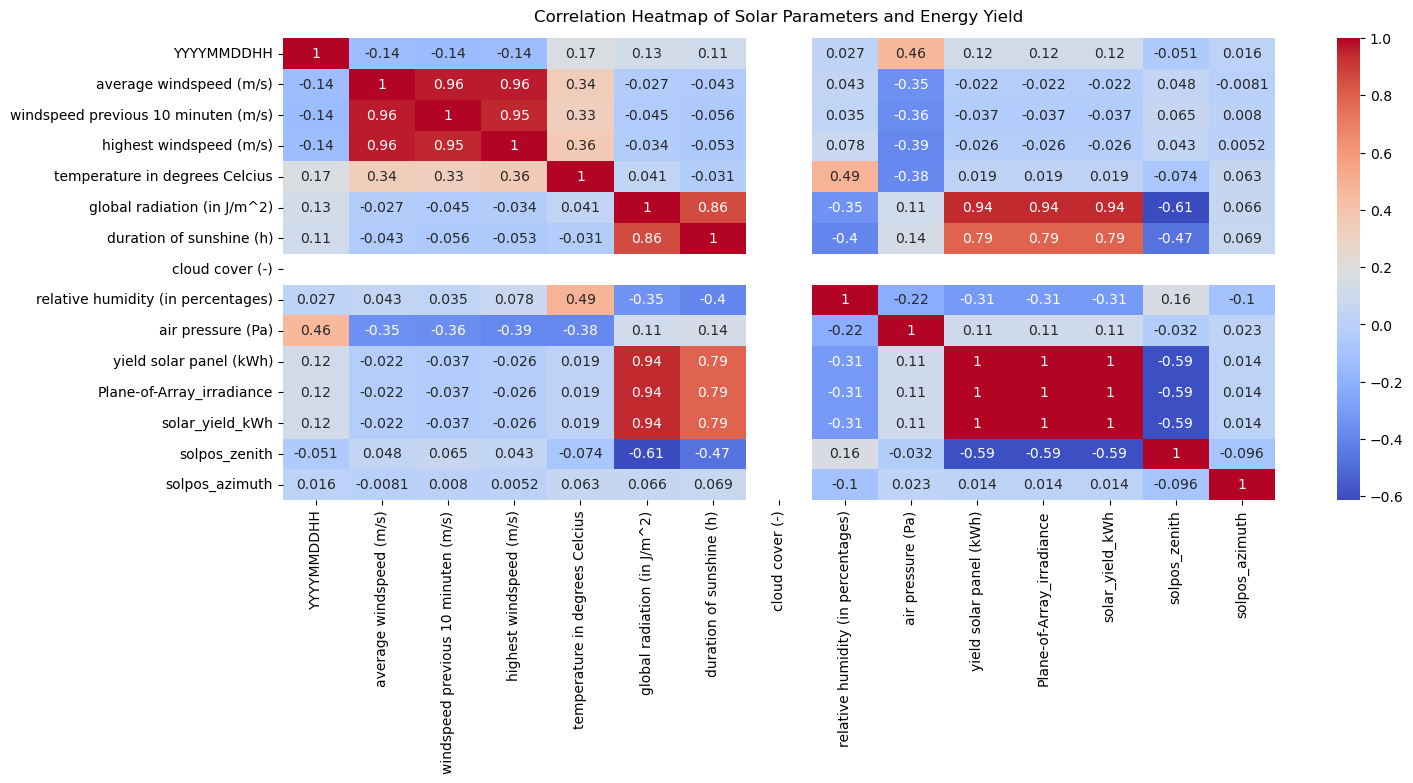

In [42]:
plt.figure(figsize=(16, 6))
heatmap=sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap of Solar Parameters and Energy Yield', fontdict={'fontsize':12}, pad=12);

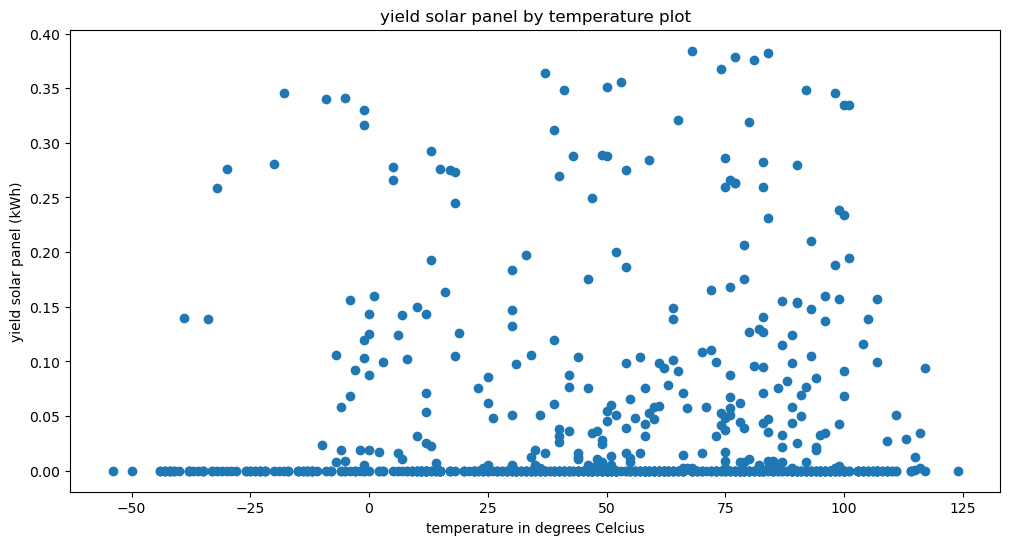

In [40]:
x= df['temperature in degrees Celcius']
y = df['yield solar panel (kWh)']
plt.figure(figsize=(12, 6))
plt.scatter(x,y)#, height = df.solar_efficiency)
plt.ylabel("yield solar panel (kWh)")
plt.xlabel("temperature in degrees Celcius")
plt.title("yield solar panel by temperature plot")
plt.show()